In [1]:
# Langkah 1 — Siapkan Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve

# Set seed biar hasil stabil
tf.random.set_seed(42)

# Baca dataset hasil dari Pertemuan 4
df = pd.read_csv("processed_kelulusan.csv")

# Pisahkan fitur dan target
X = df.drop("Lulus", axis=1)
y = df["Lulus"]

# Normalisasi (fitur dibikin rata biar training stabil)
sc = StandardScaler()
Xs = sc.fit_transform(X)

# Split data 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(Xs, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(7, 5) (1, 5) (2, 5)


In [2]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # output biner (0/1)
])

# Kompilasi model
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
es = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=32,
    callbacks=[es], verbose=1
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - AUC: 0.2500 - accuracy: 0.5714 - loss: 0.7729 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.7192
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.6250 - accuracy: 0.7143 - loss: 0.6533 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.7134
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - AUC: 0.8333 - accuracy: 0.5714 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.7079
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.8333 - accuracy: 0.7143 - loss: 0.5978 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.7029
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.9167 - accuracy: 0.7143 - loss: 0.5626 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.6984
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.6667 - accuracy: 0.5714 - loss: 0.6596 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.6938
Epoch 7/100
1/

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print("Test Acc:", acc, "AUC:", auc)

y_proba = model.predict(X_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


Test Acc: 1.0 AUC: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
[[1 0]
 [0 1]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2



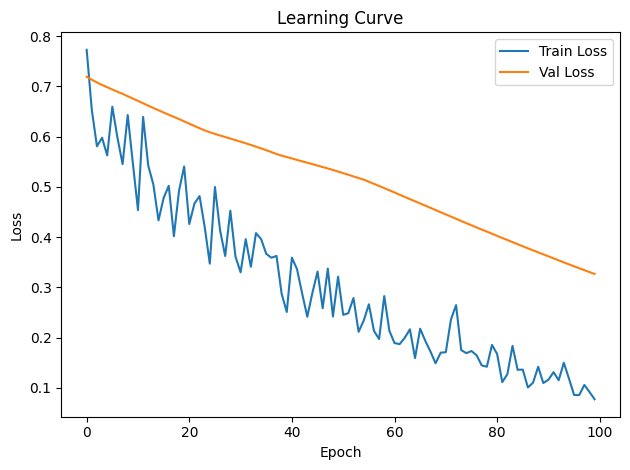

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.title("Learning Curve")
plt.tight_layout(); plt.savefig("learning_curve.png", dpi=120)
